In [1]:
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from htmresearch.support.cans.utils import *
from htmresearch.support.cans.basic_dynamics import *
%load_ext autoreload
%autoreload 2


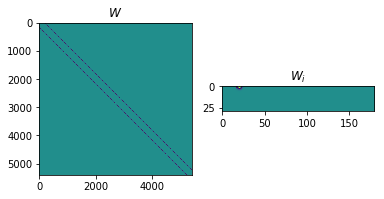

In [72]:

# Set up the shape 
# of the cortical sheet
xy_ratio = 6.

nx = 30
ny = nx*int(xy_ratio)
n  = nx*ny 



rx  = nx*40./60.
ry  = rx*xy_ratio


# Positions of neurons on cortical sheet
X = np.indices((nx,ny)).reshape((2,-1)).T/np.array([[float(nx), float(ny)]])
X[:,0] *= rx
X[:,1] *= ry

# Distance matrix of neurons
D = np.zeros((n, n))
for i in range(n):
    for j in range(n):
            D[i,j] = np.linalg.norm( X[i] - X[j])

# Function encoding the connection strength 
# based on distance
J = mexican_hat

# Create a weight matrix given J and D
# basiclally J(D) with some normalization...
W = create_W(J, D)


# Visualize
fig, ax = plt.subplots(1,2)
ax[0].imshow(W)
ax[0].set_title("$W$")
i = 200
ax[1].imshow(W[i].reshape((nx,ny)))
ax[1].set_title("$W_{i}$")
plt.show()

# plt.plot(W[200])
# plt.show()



(4, 2)


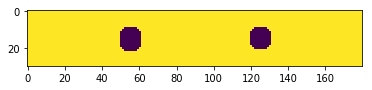

In [106]:
# Creating a mask 
# encoding "topological defects"

mask = np.ones((nx,ny))


# # num_areas = 6
R = np.array([
    [14,55],
    [16,55],
    [14,125],
    [15,125]
])/np.array([[float(nx), float(ny)]])
R[:,0] *= rx
R[:,1] *= ry
print R.shape

mask = mask.reshape(-1)
for i in range(n):
    dist_to_pins = np.amin( np.linalg.norm(R - X[i].reshape((1,2)), axis=1)) 
    if dist_to_pins < 4:
        mask[i] = 0.

plt.imshow(mask.reshape((nx,ny)))
mask = mask.reshape(-1)


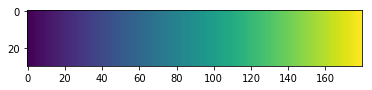

In [107]:
beta_mask = np.ones((nx,ny))*1.
beta_mask = beta_mask*np.linspace(1.5,4.,num=ny).reshape((1,ny))


# beta_mask[:,ny//2:] = 3.
# mask[10:20,50:60]    = 0.
# # mask[10:20,115:125]  = 0.


# R = np.indices((nx,ny)).reshape((2,-1)).T/np.array([[float(nx), float(ny)]])
# R[:,0] *= rx
# R[:,1] *= ry

# R = R[np.random.choice(n,size=5, replace=False)]

# rnd = np.random.sample(5)

# beta_mask = np.zeros(n)
# for i in range(n):
#     j = np.argmin( np.linalg.norm(R - X[i], axis=1))
#     beta_mask[i] = 2.5 + (rnd[j] - 0.5)*1.

    
plt.imshow(beta_mask.reshape((nx,ny)))
plt.show()
beta_mask = beta_mask.reshape(-1)


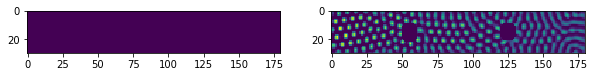

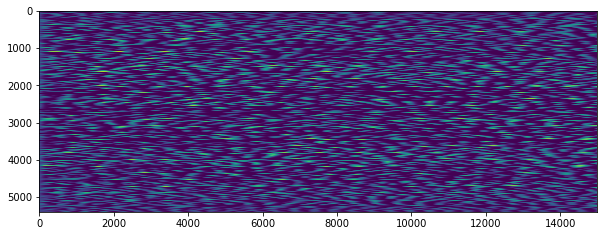

In [108]:
from htmresearch.support.gridcells.utils import cross_correlate
from scipy import ndimage
import numpy.fft as fft
from scipy.special import expit




T = 15000
# X = np.linspace(0.2,0.4,num=T)

S = np.zeros((T,n))




S[0] = np.zeros(n)
# S[0] = np.random.sample(n)*0.001


Beta = np.ones((T,n))*0.0




for t in range(1,T):
    
    s = S[t-1]
    b = np.zeros(n)
    
    tonic = 0.01
    beta  = Beta[t-1]
    
    s_ = evolve_step(W, b  + tonic, s, beta_mask*beta, mask=mask) 
#     s_ = evolve_step(W, b  + tonic, s) 
    S[t]    = s_

    alpha = 0.01
    Beta[t] = (1. - alpha)*Beta[t-1] - alpha*(s_ - np.mean(s_))


fig, ax = plt.subplots(1, 2, figsize=(10, 5));
ax[0].imshow(S[0].reshape((nx,ny)), label="$s_0$")
ax[1].imshow(S[-1].reshape((nx,ny)), label="$s_1$")
plt.show()


plt.figure(figsize=(10,5))
plt.imshow(S.T)
plt.show()





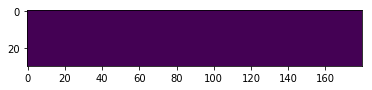

In [100]:

pixel_mask = np.ones((nx,ny))

# for i in range(0,nx, 3):
#     for j in range(0,ny, 3):
#         pixel_mask[i,j] = 1.
        
        
plt.imshow(pixel_mask)



In [101]:

    
S_, V_, C = get_data_flow_and_color_maps(S[-6000:], nx,ny, pixel_mask=pixel_mask, t_step=10)




done


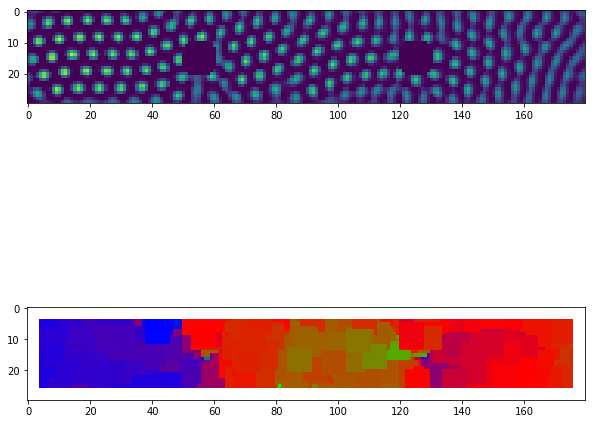

In [112]:
import matplotlib.animation as animation


def update(num, data, a):
    S_, C, V_ = data
    a[0].set_data(S_[num].reshape((nx, ny)))
    a[1].set_data(C[num].reshape((nx, ny, 3)))
    

    return a[0],a[1]




fig, ax   = plt.subplots(2,1, figsize=(10,10))

a0  = ax[0].imshow(S_[0].reshape((nx,ny)), animated=True, vmin=np.amin(S_), vmax=np.amax(S_))
a1  = ax[1].imshow(C[0].reshape((nx,ny,3)), animated=True)

ani = animation.FuncAnimation(fig, update, len(S_), fargs=((S_,C, V_), (a0,a1)),
                                   interval=10, blit=True)

ani.save('moving_bumps_right_gradient.mp4')
print "done"
# plt.show()

(590, 3600, 2)
0.0170941647589 0.0


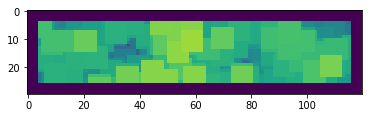

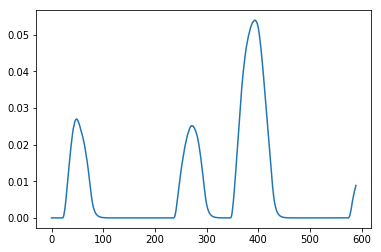

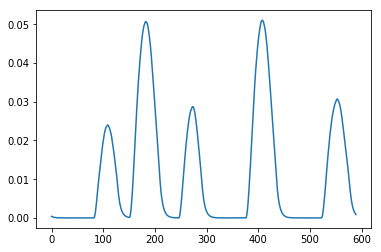

In [53]:

S_= S_.reshape((-1,nx,ny))

 
plt.plot(S_[:,15,15])
plt.show()

plt.plot(S_[:,15,45])

In [393]:
from htmresearch.support.gridcells.utils import cross_correlate


t = -1

img = S_.reshape((-1,nx,ny))
plt.imshow(img)
plt.show()

i, j = []
w = 20
patch = img[i-w:i+w,j-w:j+w]

auto = cross_correlate(patch,patch)

plt.imshow(auto)

